#### Training a computer vision model for Birds Classification

## 0. Importing the libraries

In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import v2
import torch.nn as nn
import pathlib
import os
import numpy as np
import torchinfo

try:
    from scripts import model_setup
    from scripts import utilities
except ImportError:
    !git clone https://github.com/thomaspierantozzi/PyTorch_Course_by_Daniel_Bourke
    !mv PyTorch_Course_by_Daniel_Bourke/05_PyTorch_Food101/scripts/ .
    !rm -rf ./PyTorch_Course_by_Daniel_Bourke
    from scripts import model_setup


## 1. Downloading the dataset and creating the DataLoaders

In [2]:
IMAGEFOLDER = pathlib.Path('./ImageFolder')
DATASET_TRAIN_FOLDER = IMAGEFOLDER / 'train'
DATASET_TEST_FOLDER = IMAGEFOLDER / 'cv'
MODEL_FOLDER = pathlib.Path('./models')

if not MODEL_FOLDER.exists():
    os.mkdir(MODEL_FOLDER)
    
logger = utilities.Logging_Agent(log_path=MODEL_FOLDER)
logger.write_log('The notebook has been initialized...')

The notebook has been initialized...


In [4]:
model_vit = model_setup.ViT_B_16(name='ViT-B-16', SWAG_weights=True)
model_vit.transformers()
logger.write_log(f'The model {model_vit.name} has been initialized...')

The model ViT-B-16 has been initialized...


#### Since having the correct number of classes is needed to set the classifier layer of the model, we start initializing our DataSet

In [5]:
train_transform = nn.Sequential(
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True), #just to be sure that the order of the dimension is consistent with what needed in pytorch
    v2.RandomRotation(degrees=30),
    v2.RandomPerspective(p=0.3),
    v2.RandomHorizontalFlip(p=0.3),
    model_vit.transformers()
)

cv_transform = nn.Sequential(
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True), #just to be sure that the
    model_vit.transformers()
)

logger.write_log(f'TRAIN TRANSFORMER:{train_transform}\nCV TRANSFORMER: {cv_transform}')

TRAIN TRANSFORMER:Sequential(
  (0): ToImage()
  (1): ToDtype(scale=True)
  (2): RandomRotation(degrees=[-30.0, 30.0], interpolation=InterpolationMode.NEAREST, expand=False, fill=0)
  (3): RandomPerspective(p=0.3, distortion_scale=0.5, interpolation=InterpolationMode.BILINEAR, fill=0)
  (4): RandomHorizontalFlip(p=0.3)
  (5): ImageClassification(
      crop_size=[384]
      resize_size=[384]
      mean=[0.485, 0.456, 0.406]
      std=[0.229, 0.224, 0.225]
      interpolation=InterpolationMode.BICUBIC
  )
)
CV TRANSFORMER: Sequential(
  (0): ToImage()
  (1): ToDtype(scale=True)
  (2): ImageClassification(
      crop_size=[384]
      resize_size=[384]
      mean=[0.485, 0.456, 0.406]
      std=[0.229, 0.224, 0.225]
      interpolation=InterpolationMode.BICUBIC
  )
)


In [12]:
train_dataset = ImageFolder(
    root=DATASET_TRAIN_FOLDER,
    transform=train_transform
)

cv_dataset = ImageFolder(
    root=DATASET_TEST_FOLDER,
    transform=cv_transform
)

NUM_CLASSES = len(train_dataset.class_to_idx)

logger.write_log(f'The datasets are initialized...')

The datasets are initialized...


#### We will use a different set of weights compared to the default for the ViT_B_16. This set is reported to be more accurate and most importantly uses a different resize. It works with 384x384 pictures; that should help a lot gaining more details from the pictures during training

In [13]:
torchinfo.summary(model_vit,
                  input_size=(32, 3, 384, 384),
                  col_names=["input_size", "output_size", "num_params", "trainable"],
                  row_settings=['var_names']
                  )

Layer (type (var_name))                                           Input Shape               Output Shape              Param #                   Trainable
ViT_B_16 (ViT_B_16)                                               [32, 3, 384, 384]         [32, 1000]                --                        False
├─VisionTransformer (pre_trained_model)                           [32, 3, 384, 384]         [32, 1000]                768                       False
│    └─Conv2d (conv_proj)                                         [32, 3, 384, 384]         [32, 768, 24, 24]         (590,592)                 False
│    └─Encoder (encoder)                                          [32, 577, 768]            [32, 577, 768]            443,136                   False
│    │    └─Dropout (dropout)                                     [32, 577, 768]            [32, 577, 768]            --                        --
│    │    └─Sequential (layers)                                   [32, 577, 768]            [32, 57

In [14]:
for param in model_vit.parameters():
    param.requires_grad = False

In [15]:
model_vit.pre_trained_model.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [16]:
model_vit.pre_trained_model.heads = nn.Sequential(
    nn.Linear(in_features=768, out_features=NUM_CLASSES),
)

logger.write_log(f'The model has been processed to get a feature extractor + a classifier head...')

The model has been processed to get a feature extractor + a classifier head...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1452677..2.2489522].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.2370965..2.5215256].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.2861688..2.442118].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.282561..2.3517811].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.2394948..2.676014].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.303205..2.7867715].


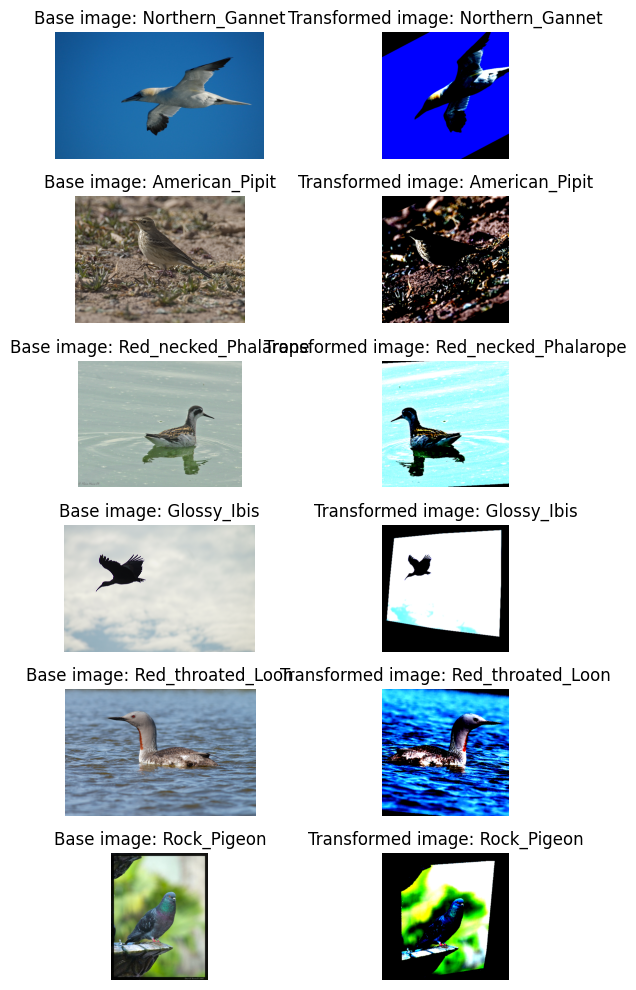

In [17]:
utilities.plot_samples_transformed(
    path=DATASET_TRAIN_FOLDER,
    classes_names=train_dataset.classes,
    transform=train_transform,
)

In [18]:
BATCH_SIZE = 32 #with a minibatch of 32 pictures, torchinfo estimates to have a 10Gb memory usage
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    shuffle=True,
    batch_size=BATCH_SIZE,
    num_workers=4,
)

cv_loader = torch.utils.data.DataLoader(
    cv_dataset,
    batch_size=BATCH_SIZE,
    num_workers=4,
)

In [19]:
classes_dict = train_dataset.class_to_idx
logger.write_log(f'The classes are initialized...\n\t{classes_dict}')

The classes are initialized...
	{'American_Golden_Plover': 0, 'American_Pipit': 1, 'Arctic_Tern': 2, 'Bairds_Sandpiper': 3, 'Barn_Swallow': 4, 'Black_Tern': 5, 'Black_bellied_Plover': 6, 'Black_billed_Cuckoo': 7, 'Black_crowned_Night_Heron': 8, 'Black_legged_Kittiwake': 9, 'Bobolink': 10, 'Bohemian_Waxwing': 11, 'Brant': 12, 'Canada_Goose': 13, 'Caspian_Tern': 14, 'Cattle_Egret': 15, 'Common_Eider': 16, 'Common_Goldeneye': 17, 'Common_Loon': 18, 'Common_Merganser': 19, 'Common_Murre': 20, 'Common_Raven': 21, 'Common_Redpoll': 22, 'Common_Tern': 23, 'Dunlin': 24, 'Eared_Grebe': 25, 'Eurasian_Collared_Dove': 26, 'European_Starling': 27, 'Franklins_Gull': 28, 'Glaucous_Gull': 29, 'Glossy_Ibis': 30, 'Golden_Eagle': 31, 'Great_Black_backed_Gull': 32, 'Great_Cormorant': 33, 'Great_Egret': 34, 'Greater_Scaup': 35, 'Greater_White_fronted_Goose': 36, 'Green_winged_Teal': 37, 'Gull_billed_Tern': 38, 'Harlequin_Duck': 39, 'Hermit_Thrush': 40, 'Herring_Gull': 41, 'Horned_Grebe': 42, 'Horned_Lark':

In [20]:
device = 'mps' if torch.mps.is_available() else 'cpu'
model_vit.to(device)
logger.write_log(f'The model is on the {device}')

The model is on the mps


In [21]:
MAX_EPOCHS=10
LEARNING_RATE = 1e-2
loss_foo = nn.CrossEntropyLoss(label_smoothing=0.15)
optimizer = torch.optim.Adam(model_vit.parameters(), lr=LEARNING_RATE, weight_decay=3e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer=optimizer,
    eta_min=1e-5,
    T_max=MAX_EPOCHS
)

logger.write_log(f'The optimizer is: {optimizer}\n\tLoss function: {loss_foo}\n\tLearning rate: {LEARNING_RATE}\n\tScheduler: {scheduler}')

The optimizer is: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.01
    lr: 0.01
    maximize: False
    weight_decay: 0.0003
)
	Loss function: CrossEntropyLoss()
	Learning rate: 0.01
	Scheduler: <torch.optim.lr_scheduler.CosineAnnealingLR object at 0x1380bfec0>


In [22]:
from time import time

from tqdm.auto import tqdm
for epoch in range(MAX_EPOCHS):
    logger.write_log(f'{' EPOCH ' + str(epoch) + ' out of ' + str(MAX_EPOCHS) :*^50}')
    epoch_loss = []
    epoch_acc = []
    epoch_train_time_start = time()
    for batch_index,(train_batch, target_batch) in enumerate(tqdm(train_loader)):
        #passing the batches to the proper device
        train_batch, target_batch = train_batch.to(device), target_batch.to(device)

        batch_train_time_start = time()
        batch_train_loss, batch_train_acc = model_vit.train_step(
            batch_X=train_batch,
            batch_y=target_batch,
            optimizer=optimizer,
            loss_foo=loss_foo,
            device=device
        )
        batch_train_time_end = time()

        #updating the lists keeping track of the losses for the batch
        epoch_loss.append(batch_train_loss)
        epoch_acc.append(batch_train_acc)

        if batch_index % 20 == 0:
            logger.write_log(model_vit.write_minibatch_results_class(
                batch_index=batch_index,
                batch_quantity=len(train_loader),
                train_loss=epoch_loss,
                batch_loss_train=batch_train_loss,
                train_acc=epoch_acc,
                batch_acc_train=batch_train_acc,
                start_time_iteration=batch_train_time_start,
                end_time_iteration=batch_train_time_end
            ))

    epoch_train_time_end = time()
    logger.write_log('\tEpoch training closed... Start evaluating the CV set...')
    epoch_cv_loss = []
    epoch_cv_acc = []
    for cv_train_batch, cv_target_batch in cv_loader:
        #passing the batches to the proper device
        cv_train_batch, cv_target_batch = cv_train_batch.to(device), cv_target_batch.to(device)

        batch_cv_loss, batch_cv_acc = model_vit.eval_step(
            batch_test_X=cv_train_batch,
            batch_test_y=cv_target_batch,
            loss_foo=loss_foo,
            device=device
        )

        epoch_cv_loss.append(batch_cv_loss)
        epoch_cv_acc.append(batch_cv_acc)

    #keep track of the history of the training metrics
    model_vit.history_update('train_loss', np.mean(epoch_loss))
    model_vit.history_update('train_acc', np.mean(epoch_acc))
    model_vit.history_update('cv_loss', np.mean(epoch_cv_loss))
    model_vit.history_update('cv_acc', np.mean(epoch_cv_acc))

    logger.write_log(model_vit.write_epoch_results_class(
        curr_iteration=epoch,
        last_iteration=MAX_EPOCHS,
        train_loss=epoch_loss,
        train_acc=epoch_acc,
        cv_loss=epoch_cv_loss,
        cv_acc=epoch_cv_acc,
        end_time_iteration=epoch_train_time_end,
        start_time_iteration= epoch_train_time_start
    ))
    
    #making a step with the scheduler
    scheduler.step()
     

**************** EPOCH 0 out of 10****************


  0%|          | 0/250 [00:03<?, ?it/s]

Intermediate results for batch 000 out of 250: Train Loss epoch:    4.921 (last:    4.921) | Train Acc. epoch:  0.00% (last:  0.00%) | Elapsed Time: 3.0 sec.
Intermediate results for batch 020 out of 250: Train Loss epoch:    5.750 (last:    5.240) | Train Acc. epoch: 31.40% (last: 46.88%) | Elapsed Time: 1.6 sec.
Intermediate results for batch 040 out of 250: Train Loss epoch:    5.381 (last:    4.942) | Train Acc. epoch: 39.48% (last: 50.00%) | Elapsed Time: 1.7 sec.
Intermediate results for batch 060 out of 250: Train Loss epoch:    5.152 (last:    5.116) | Train Acc. epoch: 43.14% (last: 46.88%) | Elapsed Time: 1.7 sec.
Intermediate results for batch 080 out of 250: Train Loss epoch:    5.062 (last:    4.424) | Train Acc. epoch: 45.49% (last: 53.12%) | Elapsed Time: 1.6 sec.
Intermediate results for batch 100 out of 250: Train Loss epoch:    5.020 (last:    3.232) | Train Acc. epoch: 47.28% (last: 75.00%) | Elapsed Time: 1.7 sec.
Intermediate results for batch 120 out of 250: Train

  0%|          | 0/250 [00:03<?, ?it/s]

Intermediate results for batch 000 out of 250: Train Loss epoch:    5.211 (last:    5.211) | Train Acc. epoch: 62.50% (last: 62.50%) | Elapsed Time: 2.3 sec.
Intermediate results for batch 020 out of 250: Train Loss epoch:    4.752 (last:    4.047) | Train Acc. epoch: 62.35% (last: 78.12%) | Elapsed Time: 1.7 sec.
Intermediate results for batch 040 out of 250: Train Loss epoch:    4.507 (last:    4.703) | Train Acc. epoch: 64.48% (last: 65.62%) | Elapsed Time: 1.6 sec.
Intermediate results for batch 060 out of 250: Train Loss epoch:    4.391 (last:    4.266) | Train Acc. epoch: 65.37% (last: 68.75%) | Elapsed Time: 1.6 sec.
Intermediate results for batch 080 out of 250: Train Loss epoch:    4.436 (last:    5.013) | Train Acc. epoch: 65.05% (last: 59.38%) | Elapsed Time: 2.0 sec.
Intermediate results for batch 100 out of 250: Train Loss epoch:    4.428 (last:    3.937) | Train Acc. epoch: 65.38% (last: 56.25%) | Elapsed Time: 1.6 sec.
Intermediate results for batch 120 out of 250: Train

  0%|          | 0/250 [00:03<?, ?it/s]

Intermediate results for batch 000 out of 250: Train Loss epoch:    4.334 (last:    4.334) | Train Acc. epoch: 59.38% (last: 59.38%) | Elapsed Time: 2.5 sec.
Intermediate results for batch 020 out of 250: Train Loss epoch:    4.460 (last:    4.185) | Train Acc. epoch: 67.11% (last: 71.88%) | Elapsed Time: 1.7 sec.
Intermediate results for batch 040 out of 250: Train Loss epoch:    4.230 (last:    4.210) | Train Acc. epoch: 68.98% (last: 75.00%) | Elapsed Time: 1.7 sec.
Intermediate results for batch 060 out of 250: Train Loss epoch:    4.170 (last:    3.694) | Train Acc. epoch: 68.95% (last: 65.62%) | Elapsed Time: 1.6 sec.
Intermediate results for batch 080 out of 250: Train Loss epoch:    4.137 (last:    4.554) | Train Acc. epoch: 69.21% (last: 59.38%) | Elapsed Time: 1.7 sec.
Intermediate results for batch 100 out of 250: Train Loss epoch:    4.092 (last:    3.890) | Train Acc. epoch: 69.31% (last: 62.50%) | Elapsed Time: 1.7 sec.
Intermediate results for batch 120 out of 250: Train

  0%|          | 0/250 [00:03<?, ?it/s]

Intermediate results for batch 000 out of 250: Train Loss epoch:    3.663 (last:    3.663) | Train Acc. epoch: 75.00% (last: 75.00%) | Elapsed Time: 2.4 sec.
Intermediate results for batch 020 out of 250: Train Loss epoch:    3.919 (last:    3.676) | Train Acc. epoch: 70.98% (last: 78.12%) | Elapsed Time: 1.6 sec.
Intermediate results for batch 040 out of 250: Train Loss epoch:    3.809 (last:    3.701) | Train Acc. epoch: 71.88% (last: 78.12%) | Elapsed Time: 1.6 sec.
Intermediate results for batch 060 out of 250: Train Loss epoch:    3.740 (last:    3.499) | Train Acc. epoch: 71.82% (last: 65.62%) | Elapsed Time: 1.6 sec.
Intermediate results for batch 080 out of 250: Train Loss epoch:    3.662 (last:    2.746) | Train Acc. epoch: 72.88% (last: 84.38%) | Elapsed Time: 1.6 sec.
Intermediate results for batch 100 out of 250: Train Loss epoch:    3.635 (last:    3.927) | Train Acc. epoch: 73.11% (last: 75.00%) | Elapsed Time: 1.6 sec.
Intermediate results for batch 120 out of 250: Train

  0%|          | 0/250 [00:03<?, ?it/s]

Intermediate results for batch 000 out of 250: Train Loss epoch:    4.222 (last:    4.222) | Train Acc. epoch: 62.50% (last: 62.50%) | Elapsed Time: 2.8 sec.
Intermediate results for batch 020 out of 250: Train Loss epoch:    3.354 (last:    2.984) | Train Acc. epoch: 76.49% (last: 75.00%) | Elapsed Time: 1.6 sec.
Intermediate results for batch 040 out of 250: Train Loss epoch:    3.211 (last:    3.319) | Train Acc. epoch: 78.66% (last: 81.25%) | Elapsed Time: 1.8 sec.
Intermediate results for batch 060 out of 250: Train Loss epoch:    3.180 (last:    3.147) | Train Acc. epoch: 78.23% (last: 75.00%) | Elapsed Time: 1.6 sec.
Intermediate results for batch 080 out of 250: Train Loss epoch:    3.148 (last:    3.513) | Train Acc. epoch: 77.85% (last: 71.88%) | Elapsed Time: 1.7 sec.
Intermediate results for batch 100 out of 250: Train Loss epoch:    3.134 (last:    3.070) | Train Acc. epoch: 77.35% (last: 81.25%) | Elapsed Time: 1.7 sec.
Intermediate results for batch 120 out of 250: Train

  0%|          | 0/250 [00:03<?, ?it/s]

Intermediate results for batch 000 out of 250: Train Loss epoch:    2.982 (last:    2.982) | Train Acc. epoch: 81.25% (last: 81.25%) | Elapsed Time: 2.4 sec.
Intermediate results for batch 020 out of 250: Train Loss epoch:    2.854 (last:    2.759) | Train Acc. epoch: 80.95% (last: 81.25%) | Elapsed Time: 1.6 sec.
Intermediate results for batch 040 out of 250: Train Loss epoch:    2.779 (last:    2.818) | Train Acc. epoch: 80.79% (last: 81.25%) | Elapsed Time: 1.6 sec.
Intermediate results for batch 060 out of 250: Train Loss epoch:    2.704 (last:    2.457) | Train Acc. epoch: 81.10% (last: 81.25%) | Elapsed Time: 1.6 sec.
Intermediate results for batch 080 out of 250: Train Loss epoch:    2.666 (last:    2.552) | Train Acc. epoch: 81.13% (last: 75.00%) | Elapsed Time: 1.6 sec.
Intermediate results for batch 100 out of 250: Train Loss epoch:    2.637 (last:    2.918) | Train Acc. epoch: 81.25% (last: 81.25%) | Elapsed Time: 1.6 sec.
Intermediate results for batch 120 out of 250: Train

  0%|          | 0/250 [00:04<?, ?it/s]

Intermediate results for batch 000 out of 250: Train Loss epoch:    2.073 (last:    2.073) | Train Acc. epoch: 90.62% (last: 90.62%) | Elapsed Time: 2.4 sec.
Intermediate results for batch 020 out of 250: Train Loss epoch:    2.300 (last:    1.977) | Train Acc. epoch: 85.42% (last: 100.00%) | Elapsed Time: 1.7 sec.
Intermediate results for batch 040 out of 250: Train Loss epoch:    2.242 (last:    1.939) | Train Acc. epoch: 86.51% (last: 93.75%) | Elapsed Time: 1.6 sec.
Intermediate results for batch 060 out of 250: Train Loss epoch:    2.189 (last:    2.045) | Train Acc. epoch: 87.30% (last: 93.75%) | Elapsed Time: 1.6 sec.
Intermediate results for batch 080 out of 250: Train Loss epoch:    2.171 (last:    2.171) | Train Acc. epoch: 86.69% (last: 87.50%) | Elapsed Time: 1.7 sec.
Intermediate results for batch 100 out of 250: Train Loss epoch:    2.154 (last:    1.782) | Train Acc. epoch: 86.88% (last: 93.75%) | Elapsed Time: 1.7 sec.
Intermediate results for batch 120 out of 250: Trai

  0%|          | 0/250 [00:03<?, ?it/s]

Intermediate results for batch 000 out of 250: Train Loss epoch:    1.930 (last:    1.930) | Train Acc. epoch: 93.75% (last: 93.75%) | Elapsed Time: 2.5 sec.
Intermediate results for batch 020 out of 250: Train Loss epoch:    1.898 (last:    1.982) | Train Acc. epoch: 90.03% (last: 84.38%) | Elapsed Time: 1.6 sec.
Intermediate results for batch 040 out of 250: Train Loss epoch:    1.860 (last:    1.717) | Train Acc. epoch: 91.01% (last: 93.75%) | Elapsed Time: 1.6 sec.
Intermediate results for batch 060 out of 250: Train Loss epoch:    1.844 (last:    1.801) | Train Acc. epoch: 91.34% (last: 93.75%) | Elapsed Time: 1.6 sec.
Intermediate results for batch 080 out of 250: Train Loss epoch:    1.824 (last:    1.629) | Train Acc. epoch: 91.98% (last: 96.88%) | Elapsed Time: 1.7 sec.
Intermediate results for batch 100 out of 250: Train Loss epoch:    1.814 (last:    1.758) | Train Acc. epoch: 91.86% (last: 90.62%) | Elapsed Time: 1.7 sec.
Intermediate results for batch 120 out of 250: Train

  0%|          | 0/250 [00:03<?, ?it/s]

Intermediate results for batch 000 out of 250: Train Loss epoch:    1.595 (last:    1.595) | Train Acc. epoch: 100.00% (last: 100.00%) | Elapsed Time: 1.9 sec.
Intermediate results for batch 020 out of 250: Train Loss epoch:    1.648 (last:    1.799) | Train Acc. epoch: 94.49% (last: 84.38%) | Elapsed Time: 1.6 sec.
Intermediate results for batch 040 out of 250: Train Loss epoch:    1.640 (last:    1.650) | Train Acc. epoch: 94.66% (last: 96.88%) | Elapsed Time: 1.6 sec.
Intermediate results for batch 060 out of 250: Train Loss epoch:    1.627 (last:    1.549) | Train Acc. epoch: 95.29% (last: 100.00%) | Elapsed Time: 1.7 sec.
Intermediate results for batch 080 out of 250: Train Loss epoch:    1.619 (last:    1.607) | Train Acc. epoch: 95.52% (last: 96.88%) | Elapsed Time: 1.7 sec.
Intermediate results for batch 100 out of 250: Train Loss epoch:    1.618 (last:    1.697) | Train Acc. epoch: 95.45% (last: 87.50%) | Elapsed Time: 1.6 sec.
Intermediate results for batch 120 out of 250: Tr

  0%|          | 0/250 [00:03<?, ?it/s]

Intermediate results for batch 000 out of 250: Train Loss epoch:    1.598 (last:    1.598) | Train Acc. epoch: 96.88% (last: 96.88%) | Elapsed Time: 2.1 sec.
Intermediate results for batch 020 out of 250: Train Loss epoch:    1.529 (last:    1.514) | Train Acc. epoch: 98.21% (last: 100.00%) | Elapsed Time: 1.7 sec.
Intermediate results for batch 040 out of 250: Train Loss epoch:    1.529 (last:    1.456) | Train Acc. epoch: 97.79% (last: 100.00%) | Elapsed Time: 1.6 sec.
Intermediate results for batch 060 out of 250: Train Loss epoch:    1.531 (last:    1.618) | Train Acc. epoch: 97.59% (last: 96.88%) | Elapsed Time: 1.6 sec.
Intermediate results for batch 080 out of 250: Train Loss epoch:    1.525 (last:    1.615) | Train Acc. epoch: 97.76% (last: 96.88%) | Elapsed Time: 1.7 sec.
Intermediate results for batch 100 out of 250: Train Loss epoch:    1.523 (last:    1.482) | Train Acc. epoch: 97.90% (last: 100.00%) | Elapsed Time: 1.7 sec.
Intermediate results for batch 120 out of 250: Tr

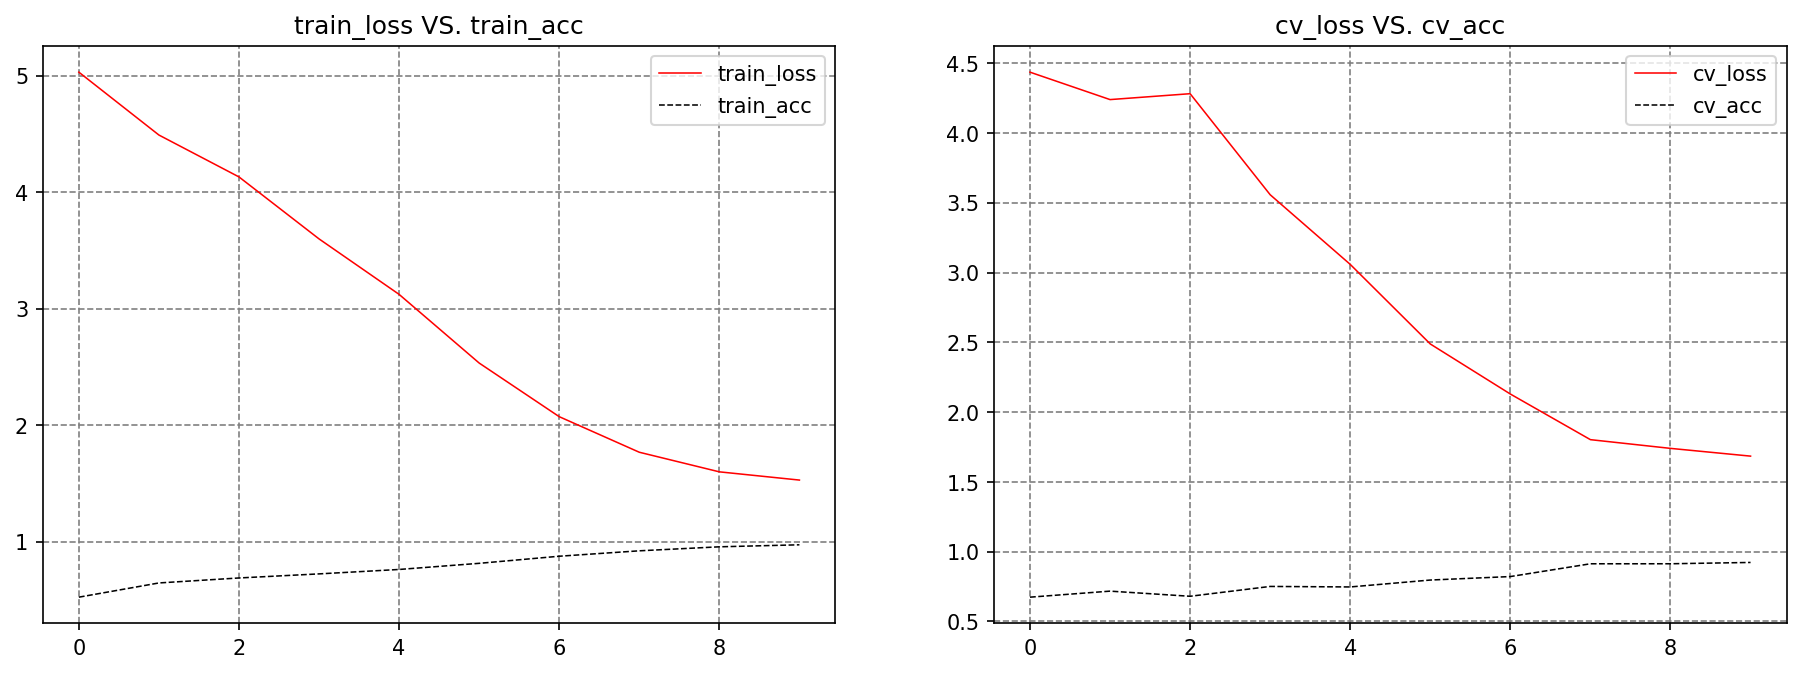

In [23]:
import matplotlib.pyplot as plt
metrics = [('train_loss', 'train_acc'),
           ('cv_loss', 'cv_acc')]

fig = plt.figure(figsize=[15, 5], dpi=150)
for index, (loss, acc) in enumerate(metrics):
    fig.add_subplot(1, 2, index + 1)
    plt.plot(
        np.arange(len(model_vit.history[loss])),
        model_vit.history[loss],
        label=loss,
        color='red',
        linewidth = 0.75,
    )
    plt.plot(
        np.arange(len(model_vit.history[loss])),
        model_vit.history[acc],
        label = acc,
        color='black',
        linewidth = 0.75,
        linestyle='--'
    )
    plt.legend()
    plt.title(f'{loss } VS. {acc}')


    plt.grid(linestyle='--', color='gray')

plt.savefig(MODEL_FOLDER / 'loss_acc_history.jpg')

In [24]:
utilities.save_model(
    path=MODEL_FOLDER,
    model=model_vit,
    optimizer=optimizer,
    epoch_nr=MAX_EPOCHS,
    learning_rate=LEARNING_RATE,
    batch_size=BATCH_SIZE,
    nr_classes=len(classes_dict),
)
logger.write_log(f'Model saved at {MODEL_FOLDER}')

Model metrics history saved in :
	models
Model saved at models
